<a href="https://colab.research.google.com/github/dionq99/Hacktiv8-Assignment/blob/main/PYIM_Assgn_3_8_Dion_Qairawan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import all necessary modules**

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

tfds.disable_progress_bar()

**Download dataset**

This dataset contains comment from wikipedia talk pages that has been annotated for toxicity.

In [ ]:
dataset= tfds.load('wikipedia_toxicity_subtypes', as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/wikipedia_toxicity_subtypes/0.2.0.incompleteVYD1Q0/wikipedia_toxicity_subtypes-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/wikipedia_toxicity_subtypes/0.2.0.incompleteVYD1Q0/wikipedia_toxicity_subtypes-test.tfrecord
Dataset wikipedia_toxicity_subtypes downloaded and prepared to /root/tensorflow_datasets/wikipedia_toxicity_subtypes/0.2.0. Subsequent calls will reuse this data.


**Split dataset into training and testing subset**

In [ ]:
train_dataset, test_dataset = dataset['train'], dataset['test']
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.float32, name=None))

**Show data samples from dataset**

In [ ]:
#0-Neutral, 1-Toxic
for example, label in train_dataset.take(5):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

**Prefetch data to optimize performance**

In [ ]:
#Set buffer size and batch size for optimization
BUFFER_SIZE = 10000
BATCH_SIZE = 64

#Autotune the dataset
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#Check the autotune result, shuffled from before
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[3])
  print()
  print('labels: ', label.numpy()[3])

**Prepare Encoder layer**

In [ ]:
#Set Vocabulary size and vectorize the data
VOCAB_SIZE = 10000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

**Define Model**

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2) #number of class: 0,1
])

**Compile Model**

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

**Train the model**

In [ ]:
history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/15
2494/2494 [==============================] - 154s 56ms/step - loss: 0.1863 - accuracy: 0.9407 - val_loss: 0.1600 - val_accuracy: 0.9375
Epoch 2/15
2494/2494 [==============================] - 143s 57ms/step - loss: 0.1002 - accuracy: 0.9644 - val_loss: 0.1850 - val_accuracy: 0.9167
Epoch 3/15
2494/2494 [==============================] - 140s 56ms/step - loss: 0.0888 - accuracy: 0.9674 - val_loss: 0.1725 - val_accuracy: 0.9312
Epoch 4/15
2494/2494 [==============================] - 139s 56ms/step - loss: 0.0831 - accuracy: 0.9688 - val_loss: 0.1917 - val_accuracy: 0.9172
Epoch 5/15
2494/2494 [==============================] - 142s 57ms/step - loss: 0.0784 - accuracy: 0.9703 - val_loss: 0.1971 - val_accuracy: 0.9135
Epoch 6/15
2494/2494 [==============================] - 146s 58ms/step - loss: 0.0748 - accuracy: 0.9710 - val_loss: 0.2004 - val_accuracy: 0.9052
Epoch 7/15
2494/2494 [==============================] - 145s 58ms/step - loss: 0.0704 - accuracy: 0.9726 - val_loss: 0

**Check model's final accuracy**

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

1000/1000 [==============================] - 34s 34ms/step - loss: 0.3357 - accuracy: 0.8960
Test Loss: 0.33566582202911377
Test Accuracy: 0.8960424065589905


**Plot metric's history**

(0.0, 0.34083121828734875)

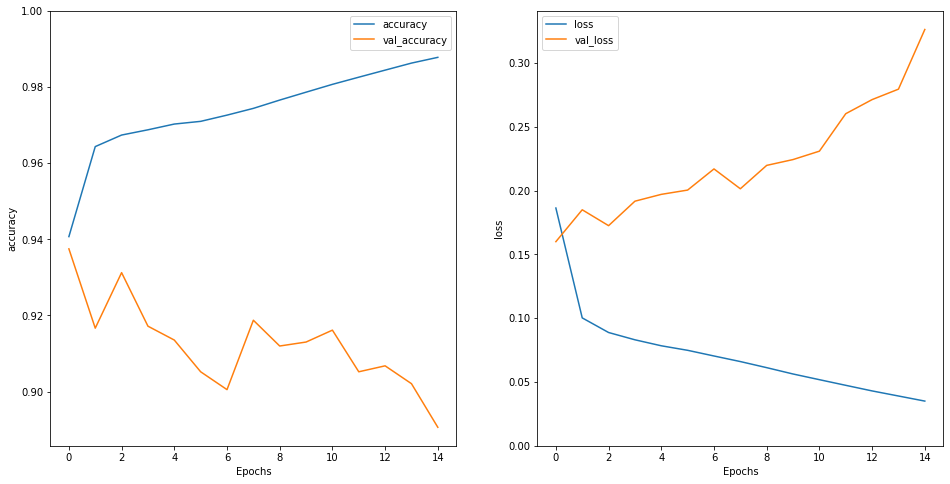

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

**Prepare list of label**

This is to help in translating prediction result into category (neutral/toxic)

In [ ]:
label_class=[]
label_class.append("Neutral") #0
label_class.append("Toxic") #1

**Try the model**

Try using the model to predict the context of an input sentence

In [ ]:
sample_text = ('anonymous is a bunch of ugly basement dwellers with no lives')
predictions = model.predict(np.array([sample_text]))
array_score = predictions[0]

i=0
max_score =-99
index = 0
for score in array_score:
  if score > max_score:
    max_score = score
    index = i
  else:
    max_score=max_score
    index=index
  i=i+1
print("Comment: " + str(sample_text))
print("This comment is:")
print(label_class[index])

Comment: anonymous is a bunch of ugly basement dwellers with no lives
This comment is:
Toxic
